In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
# from tensorflow.python.client import device_lib
# print(tf.__version__,tf.keras.__version__) # 2.10.0 / 2.10.0
# print(device_lib.list_local_devices()) # gtx 1660 / com capa 7.5 
from keras.models import Model
from keras.layers import Lambda,GaussianNoise,Activation,Dense,Input,Reshape,BatchNormalization
from keras.applications import VGG16,ResNet50V2
import keras.applications.resnet_v2 as resnet
import keras.applications.vgg16 as vgg
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import itertools
import PIL.Image as Image

In [4]:
#### Config Values ###

IMG_SHAPE = (224,224,3)
BATCH_SIZE = 32
EPOCHS = 40
SHUFFLE = True
SEED = 42
CLASSES =['cats'] # for OC-CNN
CLASSES_t =['unknown','cat','dog'] # for BoN-CNN
CLASSES_b =['wild','cat','dog'] # for Bon test
TRAIN_PATH = r"C:\Users\asiclab06\Datasets\afhq\val"
TEST_PATH = r"C:\Users\asiclab06\Datasets\afhq\train"

In [5]:
### utills 

def wrap_generator(generator): # for OC-CNN
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y

def get_label_test(test_gen):
    test_num = test_gen.samples
    label_test = []
    for i in range((test_num // test_gen.batch_size)+1):
        X,y = test_gen.next()
        label_test.append(y)
            
    label_test = np.argmax(np.vstack(label_test), axis=1)
    print(label_test.shape)
    
    return label_test

# https://ndb796.tistory.com/653 # for InstanceNormalize
def calc_mean_std(feat, eps=1e-5):
    n, c = feat.shape[0], 1
    feat_var = np.var(feat.reshape(n, c, -1), axis=2) + eps
    feat_std = tf.sqrt(feat_var).reshape(n, c, 1, 1)
    feat_mean = tf.math.reduce_mean(feat.reshape(n, c, -1), axis=2).reshape(n, c, 1, 1)
    
    return feat_mean, feat_std
    
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,cm_proba=True):
        if cm_proba:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=25)
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
        plt.yticks(tick_marks, classes, fontsize=15)

        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 14)

        plt.ylabel('True label', fontsize=20)
        plt.xlabel('Predicted label', fontsize=20)

def plot_confusion_matrix_detail(cm,classes):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_confusion_matrix(cm,classes)
    plt.subplot(122)
    plot_confusion_matrix(cm,classes,cm_proba=False)
    
def sample_from_derectory(base_path=TEST_PATH,labels=CLASSES_t): # func only this file
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    samples = []
    for ax in axes.ravel():
        label = np.random.choice(os.listdir(base_path))
        i = np.where(np.array(labels)==label)[0]
        img = np.random.choice(os.listdir(os.path.join(base_path, label)))
        img = Image.open(os.path.join(base_path, label) + "/" + img) # os.path.join
        img = img.resize(IMG_SHAPE[:2],resample=Image.Resampling.NEAREST)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label+" "+str(i))  
        samples.append(np.array(img))
    
    return np.array(samples)

def plot_result(samples,preds,true_label=None,labels=CLASSES_b):
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    
    for i,ax in enumerate(axes.ravel()):
        label = labels[preds[i]]
        l = preds[i]
        img = Image.fromarray(samples[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("P : "+label+" "+str(l))  


In [6]:
# custom normalize layer : tensorflow에 inm 없음

class InstanceNormalize(tf.keras.layers.Layer):
    def __init__(self):
        super(InstanceNormalize, self).__init__()
        if self._compute_dtype not in ("float16", "bfloat16", "float32", None):
            raise ValueError(
                "Passing `fused=True` is only supported when the compute "
                "dtype is float16, bfloat16, or float32. Got dtype: %s"
                % (self._compute_dtype,)
            )
    def instanceNormalize(self,feat,shape, eps=1e-5): # c : local var
        n = shape[0]
        c = 1
        feat_var = tf.math.reduce_variance(tf.reshape(feat,(n, c, -1)), axis=2) + eps
        feat_std = tf.reshape(tf.sqrt(feat_var),(n, c, 1))
        feat_mean = tf.reshape(tf.math.reduce_mean(tf.reshape(feat,(n, c, -1)), axis=2),(n, c, 1))

        out = (feat - feat_mean) / feat_std
        return out

    def build(self, input_shape):
        pass

    def call(self, inputs):
        inputs = tf.cast(inputs, self.compute_dtype)
        original_shape = tf.shape(inputs)
        return self.instanceNormalize(inputs,original_shape)

def instanceNormalize(feat, eps=1e-5):
    
    n, c = feat.shape[0], 1
    feat_var = tf.math.reduce_variance(tf.reshape(feat,(n, c, -1)), axis=2) + eps
    feat_std = tf.reshape(tf.sqrt(feat_var),(n, c, 1))
    feat_mean = tf.reshape(tf.math.reduce_mean(tf.reshape(feat,(n, c, -1)), axis=2),(n, c, 1))

    out = (feat - feat_mean) / feat_std
    return out


In [7]:
#### Models ###

# BoN
def get_model_bon(train=True):
    pre_process = Lambda(vgg.preprocess_input)
    vgg16 = VGG16(weights = 'imagenet', include_top = True, input_shape = IMG_SHAPE)
    vgg16 = Model(vgg16.input, vgg16.layers[-3].output)
    vgg16.trainable = False
    print(vgg16.summary())
    inp = Input(IMG_SHAPE)
    vgg_16_process = pre_process(GaussianNoise(1e-8)(inp))
    vgg_out = vgg16(vgg_16_process)
    
    noise = Lambda(tf.zeros_like)(vgg_out)
    noise = GaussianNoise(0.01)(noise)

    if train:
        vgg_out = Reshape((1,4096))(vgg_out)
        vgg_out = InstanceNormalize()(vgg_out)
        vgg_out = Reshape((-1,))(vgg_out)
        x = Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(3, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(  tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    return model

# OC-CNN+
def get_model_main(train=True):
    pre_process = Lambda(vgg.preprocess_input)
    vgg16 = VGG16(weights = 'imagenet', include_top = True, input_shape = IMG_SHAPE)
    vgg16 = Model(vgg16.input, vgg16.layers[-3].output)
    vgg16.trainable = False
    
    inp = Input(IMG_SHAPE)
    vgg_16_process = pre_process(GaussianNoise(1e-8)(inp))
    vgg_out = vgg16(vgg_16_process)
    
    noise = Lambda(tf.zeros_like)(vgg_out)
    noise = GaussianNoise(0.01)(noise)

    if train:
        vgg_out = Reshape((1,4096))(vgg_out)
        vgg_out = InstanceNormalize()(vgg_out)
        vgg_out = Reshape((-1,))(vgg_out)
        x = Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(  tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    return model

# Binary classification model
def get_model_cnn(train=True):
    pre_process = Lambda(vgg.preprocess_input)
    vgg16 = VGG16(weights = 'imagenet', include_top = True, input_shape = IMG_SHAPE)
    vgg16 = Model(vgg16.input, vgg16.layers[-3].output)
    vgg16.trainable = False
    
    inp = Input(IMG_SHAPE)
    vgg_16_process = pre_process(GaussianNoise(1e-8)(inp))
    vgg_out = vgg16(vgg_16_process)
    
    if train:
        vgg_out = Reshape((1,4096))(vgg_out)
        vgg_out = InstanceNormalize()(vgg_out)
        x = Reshape((-1,))(vgg_out)
    else:
        x = vgg_out

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(  tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    return model

In [8]:
get_model_bon()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

c:\Users\asiclab06\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# OC-CNN의 확장으로 전통적 이진 분류의 문제점을 개선
## Recognition of Unknown Labels: Expansion of OC-CNN
### - 학습되지 않은 이미지를 Unknown label로 예측합니다.
### - 훈련 이미지 : cats 300, dogs 300
### - 테스트 이미지 : 
### -- cats 1000, dogs 1000, unknown(raccoons) 195 ->  Acc : 87%
### -- cats 1000, dogs 1000, unknown(afhq_wild) 500 ->  Acc : 91%

In [6]:
### Define Dataset Generator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = SHUFFLE,
            seed=SEED,
            classes = CLASSES_t
        )
test_generator = test_datagen.flow_from_directory(
            TEST_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = False,
            classes = ['wild',CLASSES_b[1],CLASSES_b[2]]  # <=> CLASSES_b : raccoons, cats, dogs
        )

print(train_generator.classes[np.random.randint(600,size=10)])

Found 1000 images belonging to 3 classes.
Found 14630 images belonging to 3 classes.
[1 1 1 1 1 1 1 1 1 1]


In [7]:
### Fake label for Bon
def wrap_generator_bon(generator):
    while True:
        x,y = next(generator)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y
 

In [8]:
### Train BoN

train_model = get_model_bon(True)
with tf.device("/device:GPU:0"):
    train_model.fit(wrap_generator_bon(train_generator),
                        steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                        epochs=40)

Epoch 1/40


c:\Users\asiclab06\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


31/31 [==============================] - 6s 96ms/step - loss: 0.5635 - accuracy: 0.8995
Epoch 2/40
31/31 [==============================] - 3s 99ms/step - loss: 0.4359 - accuracy: 0.9990
Epoch 3/40
31/31 [==============================] - 3s 101ms/step - loss: 0.3101 - accuracy: 0.9990
Epoch 4/40
31/31 [==============================] - 3s 101ms/step - loss: 0.1908 - accuracy: 0.9985
Epoch 5/40
31/31 [==============================] - 3s 100ms/step - loss: 0.1056 - accuracy: 0.9995
Epoch 6/40
31/31 [==============================] - 3s 100ms/step - loss: 0.0582 - accuracy: 0.9995
Epoch 7/40
31/31 [==============================] - 3s 99ms/step - loss: 0.0346 - accuracy: 0.9995
Epoch 8/40
31/31 [==============================] - 3s 100ms/step - loss: 0.0232 - accuracy: 1.0000
Epoch 9/40
31/31 [==============================] - 3s 100ms/step - loss: 0.0162 - accuracy: 1.0000
Epoch 10/40
31/31 [==============================] - 3s 100ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 11/40
3

In [9]:
### BoN Test : Unknown(only raccoons), cats, dogs - 0.859 / Unknown(afhq_wild), cats, dogs - 0.9088

pred_model = get_model_bon(train=False)
pred_model.set_weights(train_model.get_weights())
ground_truth = get_label_test(test_generator)
pred_test = np.argmax(pred_model.predict(test_generator), axis=1)
main_acc = accuracy_score(ground_truth, pred_test)
print('ACCURACY:', main_acc)

(14630,)
458/458 [==============================] - 37s 80ms/step
ACCURACY: 0.9200273410799726


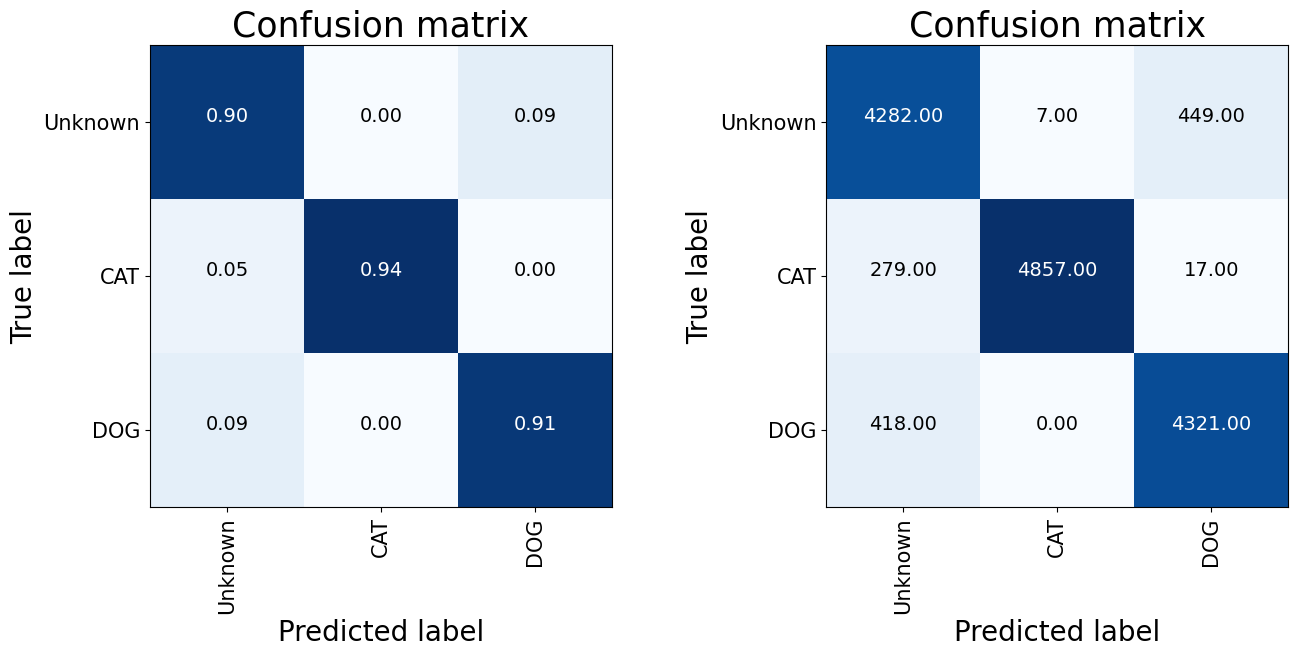

              precision    recall  f1-score   support

        wild       0.86      0.90      0.88      4738
         cat       1.00      0.94      0.97      5153
         dog       0.90      0.91      0.91      4739

    accuracy                           0.92     14630
   macro avg       0.92      0.92      0.92     14630
weighted avg       0.92      0.92      0.92     14630



In [10]:
### classification report # 라쿤이 아닌 다른 동물(cat,dog 제외) 사진 500장 모두 unknown으로 분류 

cnf_matrix = confusion_matrix(ground_truth, pred_test)
plot_confusion_matrix_detail(cnf_matrix, classes=['Unknown','CAT','DOG'])
plt.show()
print(classification_report(ground_truth,pred_test,target_names=test_generator.class_indices.keys()))

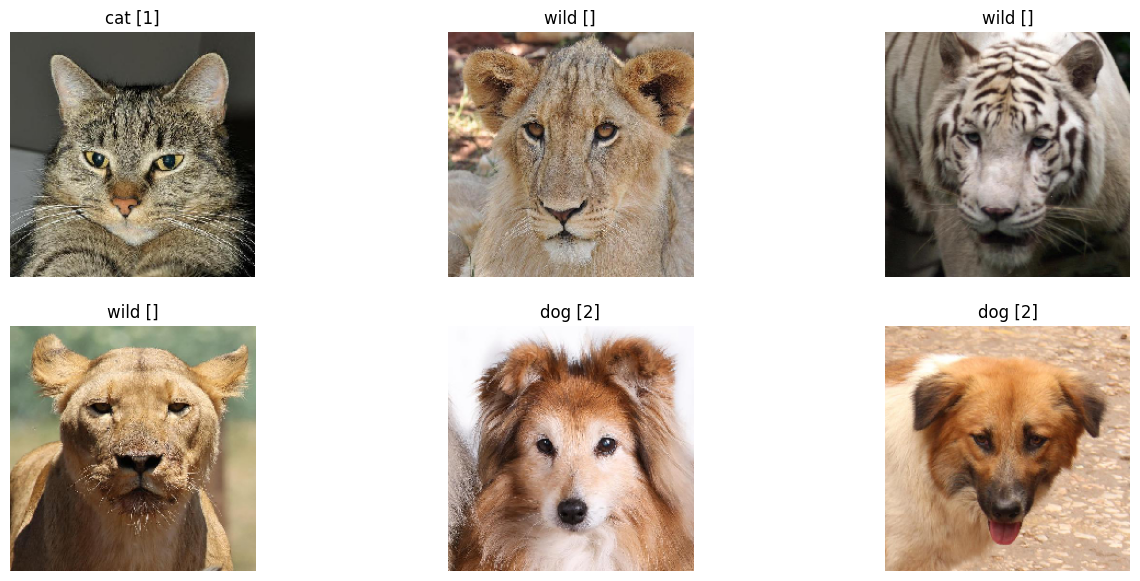

In [11]:
# Sample test

samples = sample_from_derectory()

1/1 [==============================] - 0s 81ms/step


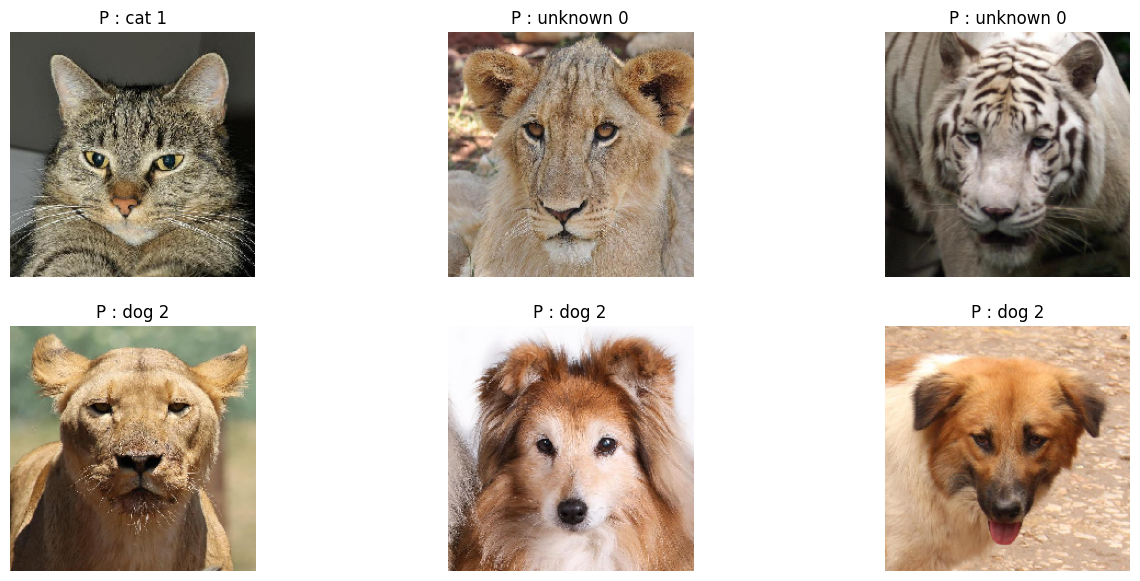

In [12]:
# Predict samples and plot result

sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds,labels=['unknown',CLASSES_t[1],CLASSES_t[2]])

1/1 [==============================] - 0s 14ms/step


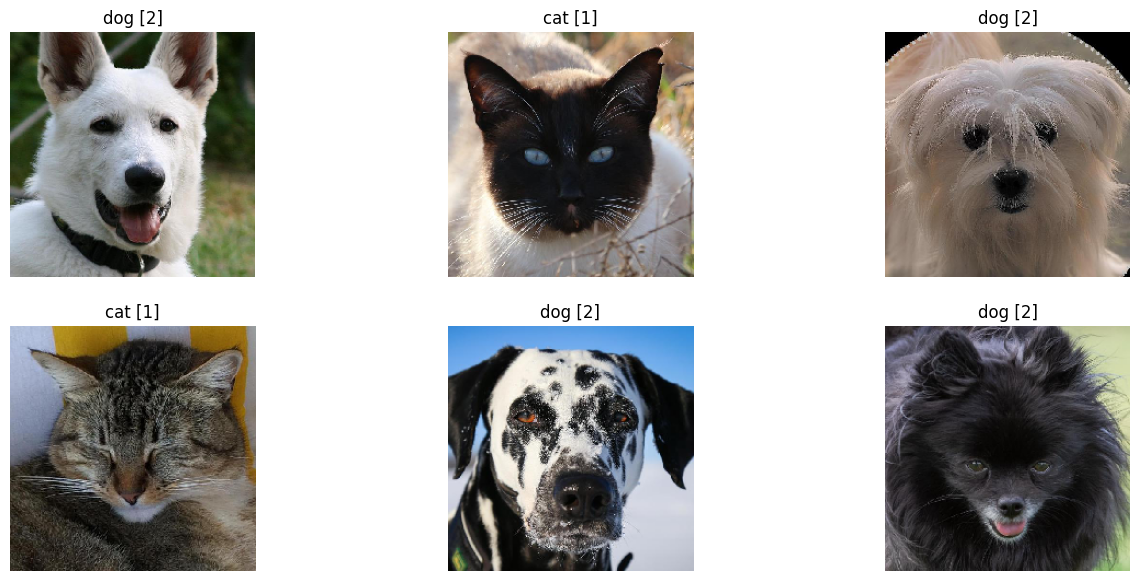

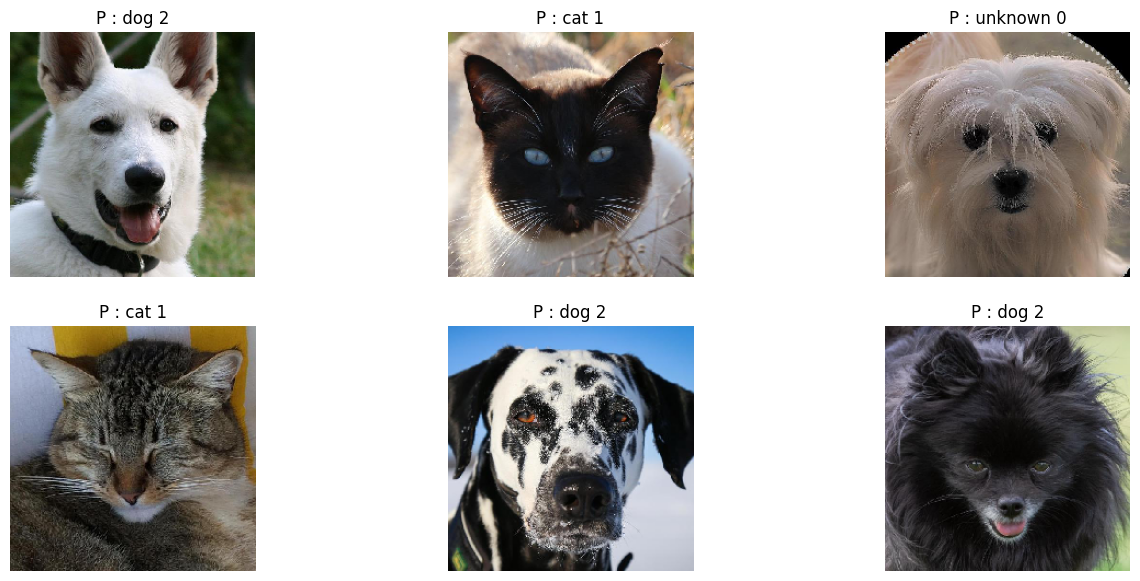

In [13]:
# Sample test
samples = sample_from_derectory()

# Predict samples and plot result
sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds,labels=['unknown',CLASSES_t[1],CLASSES_t[2]])

# OC-CNN+ : 해당 논문의 네트워크를 일부 수정 
### - 훈련 이미지 : cats 300
### - 테스트 이미지 : cats 1000, dogs(unknown) 1000
### - Acc : 94%

In [14]:
### Define Dataset Generator

train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = SHUFFLE,
            seed=SEED,
            classes = CLASSES
        )
test_generator = test_datagen.flow_from_directory(
            TEST_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = False,
            classes = [CLASSES_b[2],CLASSES_b[1]]
        )

print(train_generator.classes[np.random.randint(300,size=10)])

Found 0 images belonging to 1 classes.
Found 9892 images belonging to 2 classes.


IndexError: index 176 is out of bounds for axis 0 with size 0

In [ ]:
### Train

train_model = get_model_main()
with tf.device("/device:GPU:0"):
    train_model.fit(wrap_generator(train_generator),
                        steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                        epochs=EPOCHS)

Epoch 1/40


c:\Users\asiclab06\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


9/9 [==============================] - 2s 201ms/step - loss: 0.4457 - accuracy: 0.4983
Epoch 2/40
9/9 [==============================] - 1s 100ms/step - loss: 0.3504 - accuracy: 0.5800
Epoch 3/40
9/9 [==============================] - 1s 101ms/step - loss: 0.3388 - accuracy: 0.9967
Epoch 4/40
9/9 [==============================] - 1s 101ms/step - loss: 0.3254 - accuracy: 1.0000
Epoch 5/40
9/9 [==============================] - 1s 101ms/step - loss: 0.3078 - accuracy: 1.0000
Epoch 6/40
9/9 [==============================] - 1s 102ms/step - loss: 0.2862 - accuracy: 1.0000
Epoch 7/40
9/9 [==============================] - 1s 100ms/step - loss: 0.2632 - accuracy: 1.0000
Epoch 8/40
9/9 [==============================] - 1s 100ms/step - loss: 0.2378 - accuracy: 1.0000
Epoch 9/40
9/9 [==============================] - 1s 100ms/step - loss: 0.2111 - accuracy: 1.0000
Epoch 10/40
9/9 [==============================] - 1s 100ms/step - loss: 0.1836 - accuracy: 1.0000
Epoch 11/40
9/9 [=============

In [ ]:
### Test

pred_model = get_model_main(train=False)
pred_model.set_weights(train_model.get_weights())
ground_truth = get_label_test(test_generator)
pred_test = np.argmax(pred_model.predict(test_generator), axis=1)
main_acc = accuracy_score(ground_truth, pred_test)
print('ACCURACY:', main_acc)

(2000,)
63/63 [==============================] - 5s 84ms/step
ACCURACY: 0.9325


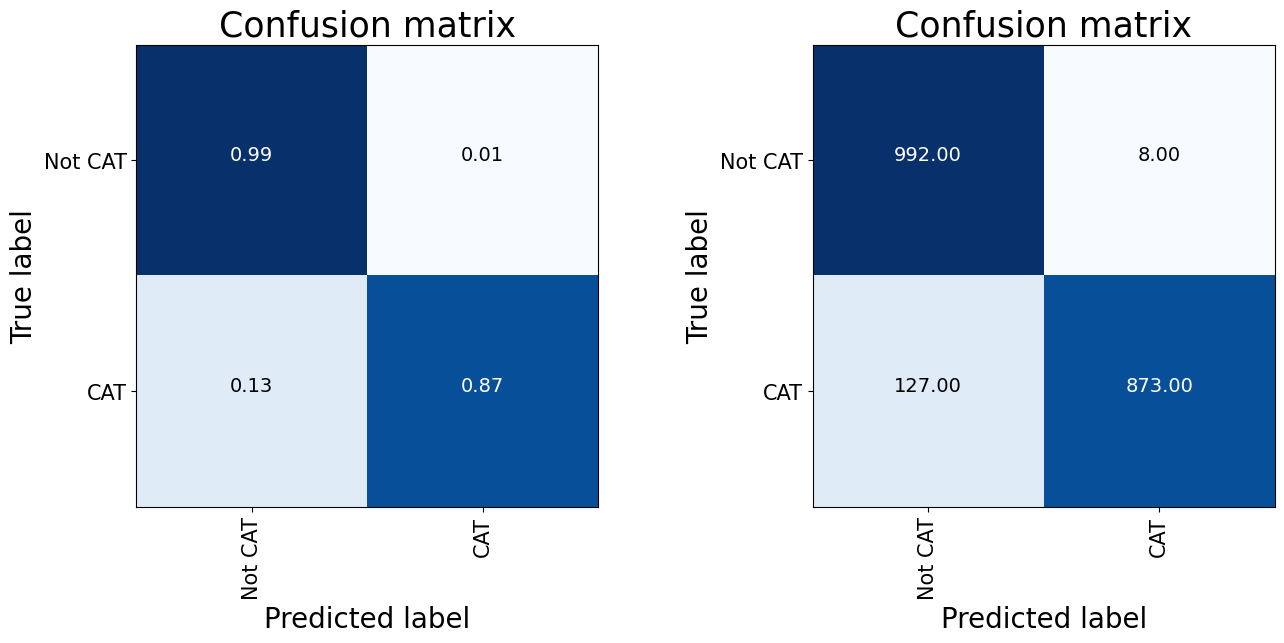

              precision    recall  f1-score   support

        dogs       0.89      0.99      0.94      1000
        cats       0.99      0.87      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.93      0.93      2000



In [ ]:
### classification report

cnf_matrix = confusion_matrix(ground_truth, pred_test)
plot_confusion_matrix_detail(cnf_matrix, classes=['Not CAT','CAT'])
plt.show()
print(classification_report(ground_truth,pred_test,target_names=test_generator.class_indices.keys()))

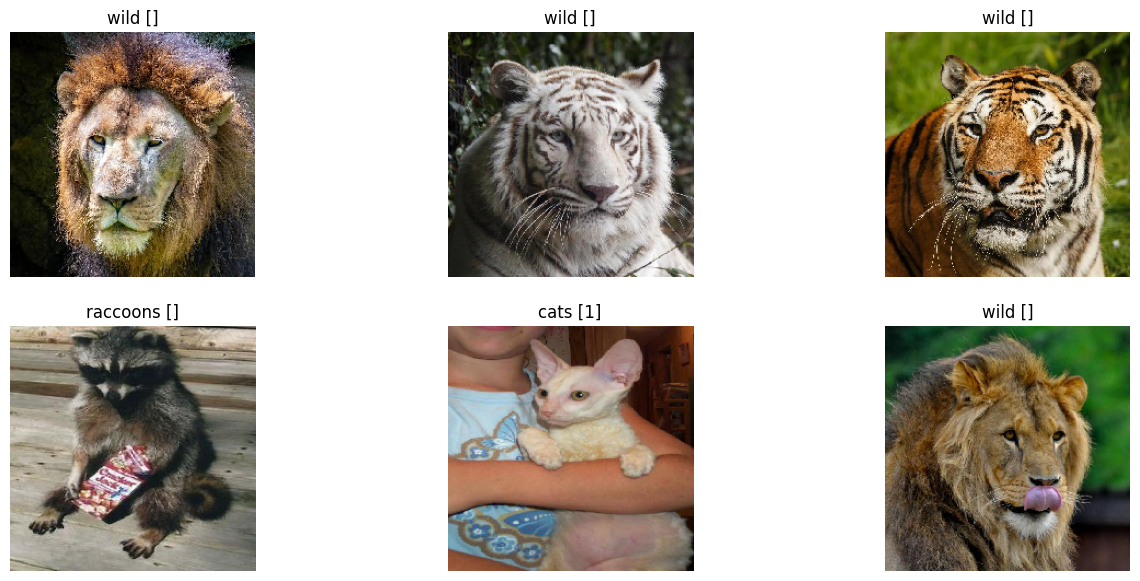

In [ ]:
# Sample test 
# * cats : 1 / dogs,raccoons : 0

samples = sample_from_derectory()

1/1 [==============================] - 0s 84ms/step


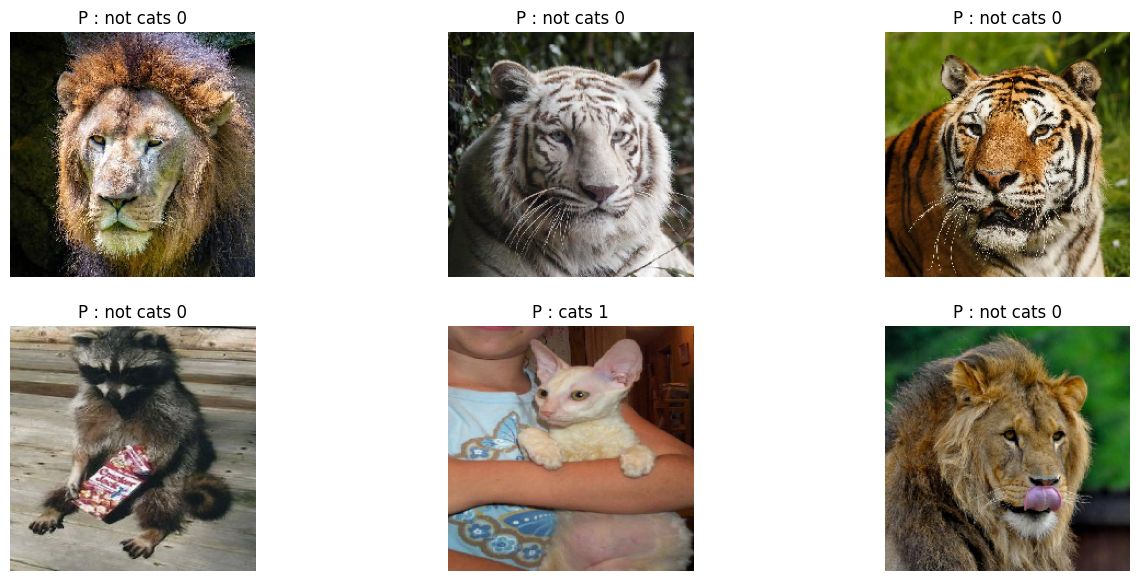

In [ ]:
# Predict samples and plot result

sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds,labels=['not cats','cats'])

# CNN : 이진분류 CNN
### - 훈련 이미지 : cats 300, dogs 300
### - 테스트 이미지 : cats 1000, dogs 1000
### - Acc : 97.6%

In [ ]:
### Define Dataset Generator

train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = SHUFFLE,
            seed=SEED,
            classes = [CLASSES_b[2],CLASSES_b[1]]
        )
test_generator = test_datagen.flow_from_directory(
            TEST_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = False,
            classes = [CLASSES_b[2],CLASSES_b[1]]
        )

print(train_generator.classes[np.random.randint(600,size=10)])

Found 600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
[1 1 1 0 1 1 0 0 0 0]


In [ ]:
### Train

train_model = get_model_cnn()
with tf.device("/device:GPU:0"):
    train_model.fit(train_generator,
                        steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                        epochs=EPOCHS)

Epoch 1/40


c:\Users\asiclab06\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18/18 [==============================] - 2s 95ms/step - loss: 0.1981 - accuracy: 0.9183
Epoch 2/40
18/18 [==============================] - 2s 93ms/step - loss: 0.0085 - accuracy: 0.9983
Epoch 3/40
18/18 [==============================] - 2s 92ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 4/40
18/18 [==============================] - 2s 93ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 5/40
18/18 [==============================] - 2s 93ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 6/40
18/18 [==============================] - 2s 95ms/step - loss: 9.3500e-04 - accuracy: 1.0000
Epoch 7/40
18/18 [==============================] - 2s 92ms/step - loss: 7.9505e-04 - accuracy: 1.0000
Epoch 8/40
18/18 [==============================] - 2s 92ms/step - loss: 6.8802e-04 - accuracy: 1.0000
Epoch 9/40
18/18 [==============================] - 2s 93ms/step - loss: 6.0356e-04 - accuracy: 1.0000
Epoch 10/40
18/18 [==============================] - 2s 93ms/step - loss: 5.3340e-04 - accuracy: 1.0000


In [ ]:
### Test

pred_model = get_model_cnn(train=False)
pred_model.set_weights(train_model.get_weights())
ground_truth = get_label_test(test_generator)
pred_test = np.argmax(pred_model.predict(test_generator), axis=1)
main_acc = accuracy_score(ground_truth, pred_test)
print('ACCURACY:', main_acc)

(2000,)
63/63 [==============================] - 5s 76ms/step
ACCURACY: 0.978


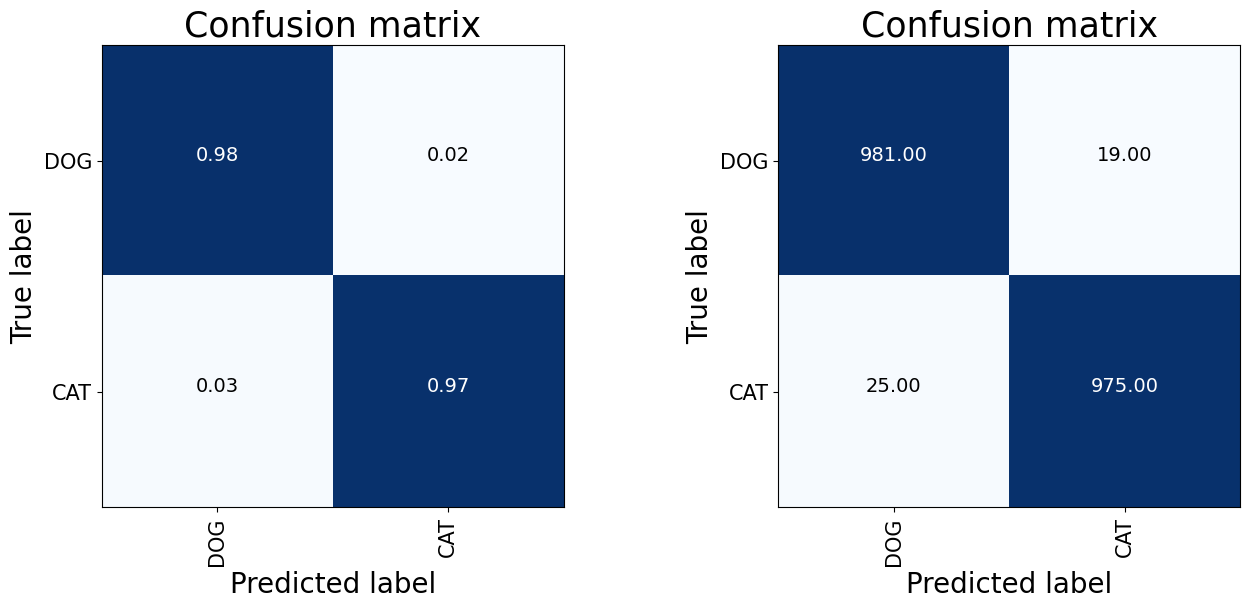

              precision    recall  f1-score   support

        dogs       0.98      0.98      0.98      1000
        cats       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
### classification report

cnf_matrix = confusion_matrix(ground_truth, pred_test)
plot_confusion_matrix_detail(cnf_matrix, classes=['DOG','CAT'])
plt.show()
print(classification_report(ground_truth,pred_test,target_names=test_generator.class_indices.keys()))

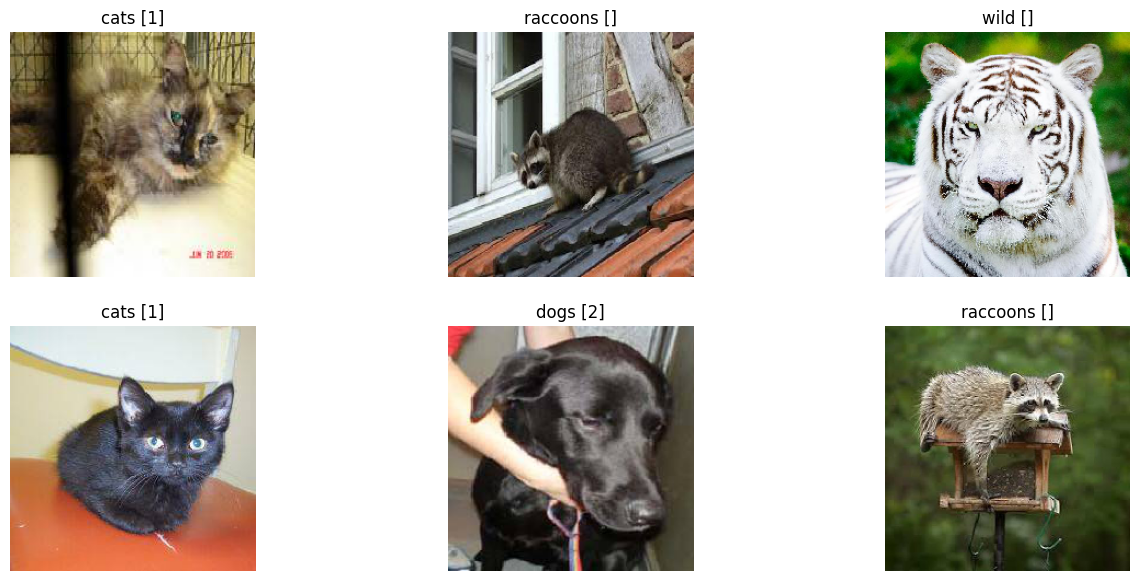

In [ ]:
# Sample test 
# * cats : 1 / dogs,raccoons : 0

samples = sample_from_derectory()

1/1 [==============================] - 0s 87ms/step


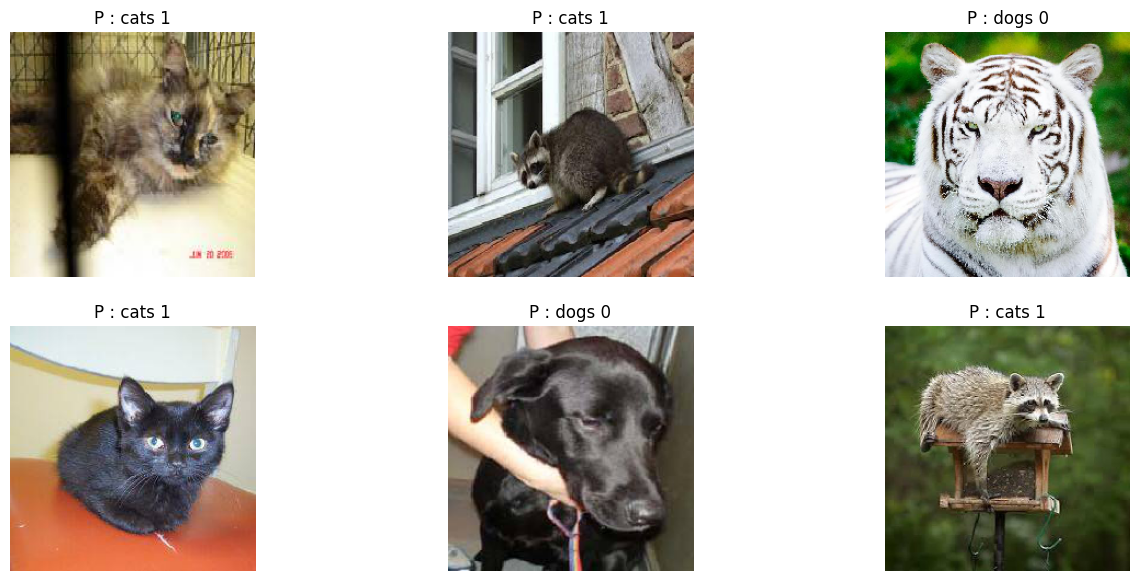

In [ ]:
# Predict samples and plot result

sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds,labels=['dogs','cats'])

### Reference
### - Oza, Poojan, and Vishal M. Patel. "One-class convolutional neural network." IEEE Signal Processing Letters 26.2 (2018): 277-281.
### - https://github.com/otkupjnoz/oc-cnn